In [2]:
#%%
#            Chem 210A  2019  Prof. McCurdy
#
"""  Template for calculating a potential curve for a diatomic or one degree of freedom 
      for a polyatomic molecule

        using psi4 as a python module
  
    Starting point for Chem 210A problems -- CWM January 7, 2019

    This example does Hartree-Fock on H2
    
    Minor changes allow MP2 and CISD calculations on this and other diatomics
    With suitable modifications in the geometry specification 
    this template can be used to calculate a bond 
    stretching curve for a polyatomic
    
"""

#%%
#                    IMPORT MODULES
#
import psi4  #  import all of psi4
#  regular expression library is used for replacing strings with numbers in geometry specification
import re as re  # regular expression library 
# numpy library is used for all numerical calculations in python that we program specifically here 
import numpy as np # numpy library for numerical calculations
import os     # operating system commands for manipulating files
import matplotlib.pyplot as plt  
from datascience import *
%matplotlib inline
plt.style.use('fast')

In [3]:
#                 SET MEMORY
#
psi4.set_memory('2048 MB')     # minimum memory should be 1/2 GB, 2GB or greater is better
#
#
#        SET FILE NAMES FOR OUTPUT FILES 
#         change names between runs to save them
#
#  File for output from Psi4 is a  .txt file 
file_string_output = 'output_potential_curve.txt'  # output file
#  molden output must be a .molden file
molden_file_name = "diatomic_scf.molden"   # molden file 
#  File for plotting potential curve 
plot_file_name = 'potcurve.dat'      # plotting file
#
# remove these files, especially the molden file if it exists
# to prevent psi4 from appending to existing file
if os.path.exists(molden_file_name):
  os.remove(molden_file_name)
if os.path.exists(plot_file_name):
  os.remove(plot_file_name)
if os.path.exists(file_string_output):
  os.remove(file_string_output)
psi4.core.set_output_file(file_string_output,False) 
print("psi4 output is directed to ",file_string_output,"\n")
#%%
# 

psi4 output is directed to  output_potential_curve.txt 



In [4]:
#                   SPECIFY GEOMETRY PYTHON OBJECT
#
# R_value  =  the internuclear distance in a0
# and must be replaced by a number using the regular expression functions
# in the for loop on distances.
#
# Specifying cartesian coordinates in this example
# Types of atoms are specified by chemical symbol
# First line is charge and spin multiplicity 
# 0 1 => neutral  singlet 
# 0 3 => neutral triplet and requires ROHF ('rohf' reference for 'scf' below)
# c1 = C_1 symmetry (no symmetry) OK for RHF (and necessary for unrestricted Hartree-Fock (UHF))
# d2h => is fastest for homonuclear diatomics.  Irreps are (in this order in some commands for open shell systems)
#   Ag   B1g   B2g   B3g    Au   B1u   B2u   B3u 
# c2v => is fastest for heteronuclear diatomics.  Irreps are (in this order in some commands for open shell systems)#
#   A1    A2    B1    B2 
#

In [5]:
molecular_geometry  =  """
      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry d2h  """

#   print the geometry template
print(molecular_geometry)
#


      0 1 
      H  0.0 0.0 0.0 
      H  0.0 0.0 R_value 
    units bohr
    symmetry d2h  


In [6]:
#  psi4 options that do not change with R value
# 
#                               BASIS SET
#  cc-pVDZ is a small correlation consistent Dunning basis - good for first calculation.
#  (Sometimes won't be  good enough for Chem 210A final answers
#  see Psi4 manual for many other built-in basis sets
#
psi4.set_options({'basis': 'cc-pvTZ'}) 
#
#                        METHOD (OR REFERENCE METHOD for MP2, CISD or CCSD)
#   Method, and/or  reference for CI or MP2 calculations is set here
# "rhf" for restricted HF for closed shells, 
# "rohf" for restricted open-shell HF for open shells, like triplets, requires other options to be set 
psi4.set_options({"reference": "rohf"})  
#  scf_type is a keyword that controls the algorithm for handling the four-index electron repulsion integrals.  
# 'pk' is a safe out-of-core algorithm using exact electron repulsion integrals.  
# 'df' denotes a density-fitted algorithm designed for computations with thousands of basis functions. 
#  It is required for MP2 (Moller-Plesset 2nd order perturbation theory)
psi4.set_options({'scf_type': 'pk'}) 
#
#                          SCF INITIAL GUESS
#  Initial guess options for SCF, very important for UHF and sometimes ROHF or RHF
#  RHF is usually not difficult to converge.
#
#psi4.set_options({'guess': 'read'})  #  can be used to follow a solution for difficult cases as R changes
#                                 #  if we run an initial point before the loop on R with another option
#                                 #  then set guess: 'read' before starting the loop which is used for subsequent points
#   guess: 'core' good for closed shell restricted Hartree-Fock 
psi4.set_options({'guess': 'core'})    # diagonalize core (nuclear attraction only) Hamiltonian for guess
#
#  some other guess options that help converge rohf and some rhf  calculations 
#psi4.set_options({'guess': 'sad'})    # superposition of atomic densities (SAD) guess
#psi4.set_options({'guess': 'gwh'})    # generalized Wolfsberg-Helmholz Huckel-like guess
psi4.set_options({"MCSCF_MAXITER":100})    # If near 500 iterations are necessary, calculation is on the edge of failure
psi4.set_options({'DIAG_METHOD':'RSP'})    # RSP form the entire H matrix and diagonalize using libciomr to obtain all eigenvalues 
                                           # found necessary for some 2 x 2 cases like sigma_g^2 + sigma_u^2 for H2
#%%
#

In [7]:
#    set the active space for CAS SCF for either single point or curve calculations
#   order of  symmetries in C2v A1    A2    B1    B2  -- see above
#                        in D2h Ag   B1g   B2g   B3g    Au   B1u   B2u   B3u
#   CASSCF can be done in either symmtery, but D2h allows explicit sigma_g^2 + sigma_u^2 configurations
psi4.set_options({'ACTIVE':[2,0,0,0,0,1,1,1]}) # sigma_g is in Ag, sigm_u is in B1u in D2h
#
#                SINGLE POINT CALCULATION 
#      uncomment to do single point calculations 
#
R = 1.4
molecular_geometry_R = re.sub("R_value",str(R),molecular_geometry)
scf_energy, wfcn = psi4.energy('casscf',molecule=psi4.geometry(molecular_geometry_R),return_wfn=True)
print("\n Single point calculation at R = ",R,"   psi4 scf energy = ", scf_energy)
print(" Writing molden file ",molden_file_name)
psi4.molden(wfcn,molden_file_name)
#exit()


 Single point calculation at R =  1.4    psi4 scf energy =  -1.1690137515655958
 Writing molden file  diatomic_scf.molden


In [8]:
#%%
#                    POTENTIAL CURVE CALCULATION
#
#  parameters for the curve
#
N_Rvals = 91  # when debugging use a small number of R values
Rmin = 0.8    # use a larger or smaller Rmin for some molecules (using bohr here) 
Rmax = 10.0
dr = (Rmax-Rmin)/(N_Rvals-1)
#

In [9]:
#  arrays for the R values and energies
#
Rvals=[]
Calculated_Energies=[]
#
#%%
#
# LOOP over R values 
#
print("\n ** Beginning potential curve calculation ** \n")
for n in range(N_Rvals):
    R = Rmin + n*dr
#
# The following command substitutes a string made from the value of the
# variable R for the the string "R_value" in the python object molecular_geometry
# to make a new object molecular_geometry_R .  It can be applied several times
# in succession, renaming the result each time, to replace several 
# strings to create a new geometry object
#
    molecular_geometry_R = re.sub("R_value",str(R),molecular_geometry)
#
#    print(molecular_geometry_R)  # print current geometry -- uncomment for debugging
#
#  method is specified here 'scf' assumes a reference to have been set
#  rhf,  rohf or uhf for example
#  'mp2'  also requires a reference (like rhf) as does 'cisd'
#
#               SCF calculation at this R point 
    psi4.set_options({'guess': 'read'})    # 
    scf_energy=psi4.energy('casscf',molecule=psi4.geometry(molecular_geometry_R) )
    print("R = ",R," scf energy =  ", scf_energy)
    Rvals.append(R)
    Calculated_Energies.append(scf_energy)
#
#  for loop ends here
##


 ** Beginning potential curve calculation ** 

R =  0.8  scf energy =   -1.0119424184524852
R =  0.9022222222222223  scf energy =   -1.0775678248883283
R =  1.0044444444444445  scf energy =   -1.1193893148574081
R =  1.1066666666666667  scf energy =   -1.145201288802327
R =  1.208888888888889  scf energy =   -1.1600225290775485
R =  1.3111111111111111  scf energy =   -1.1671960781898514
R =  1.4133333333333333  scf energy =   -1.1690077647772412
R =  1.5155555555555555  scf energy =   -1.167053363914174
R =  1.6177777777777778  scf energy =   -1.1624659309362135
R =  1.72  scf energy =   -1.1560614482516258
R =  1.8222222222222222  scf energy =   -1.1484350142141777
R =  1.9244444444444444  scf energy =   -1.1400258199880706
R =  2.0266666666666664  scf energy =   -1.1311616051722986
R =  2.1288888888888886  scf energy =   -1.1220893283179882
R =  2.231111111111111  scf energy =   -1.112996500204114
R =  2.333333333333333  scf energy =   -1.1040261435908834
R =  2.4355555555555553  sc

In [10]:
#%%
#                   MAKE OUTPUT FILE FOR PLOTTING
#  at the end of the for loop both print and make a file
#  containing the scf energies
#
f = open(plot_file_name,'w')  # optionally rename this file for the case at hand
print("\n Making plot file named ",plot_file_name)
for n in range(N_Rvals):
    print(Rvals[n],"   ",Calculated_Energies[n],file=f)
#   print(Rvals[n],"   ",Calculated_Energies[n]) # echo plotting output to console
#
#%%


 Making plot file named  potcurve.dat


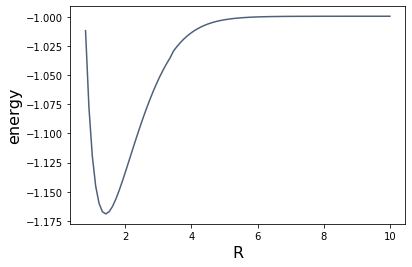

In [11]:
three_sigma_2pi= Table().with_columns("R",Rvals,"energy",Calculated_Energies)
three_sigma_2pi.plot(0)

In [11]:
#
#  MAKE PLOTS FROM THE OUTPUT FILE OR PUT PLOTTING COMMANDS HERE
#  FOR A PROPERLY LABELED GRAPH 
#  plotting with xmgrace is recommended, and easier than plotting
#  several cases from this python script
#
exit()
